Text(0.045, 0.5, 'Simulations')

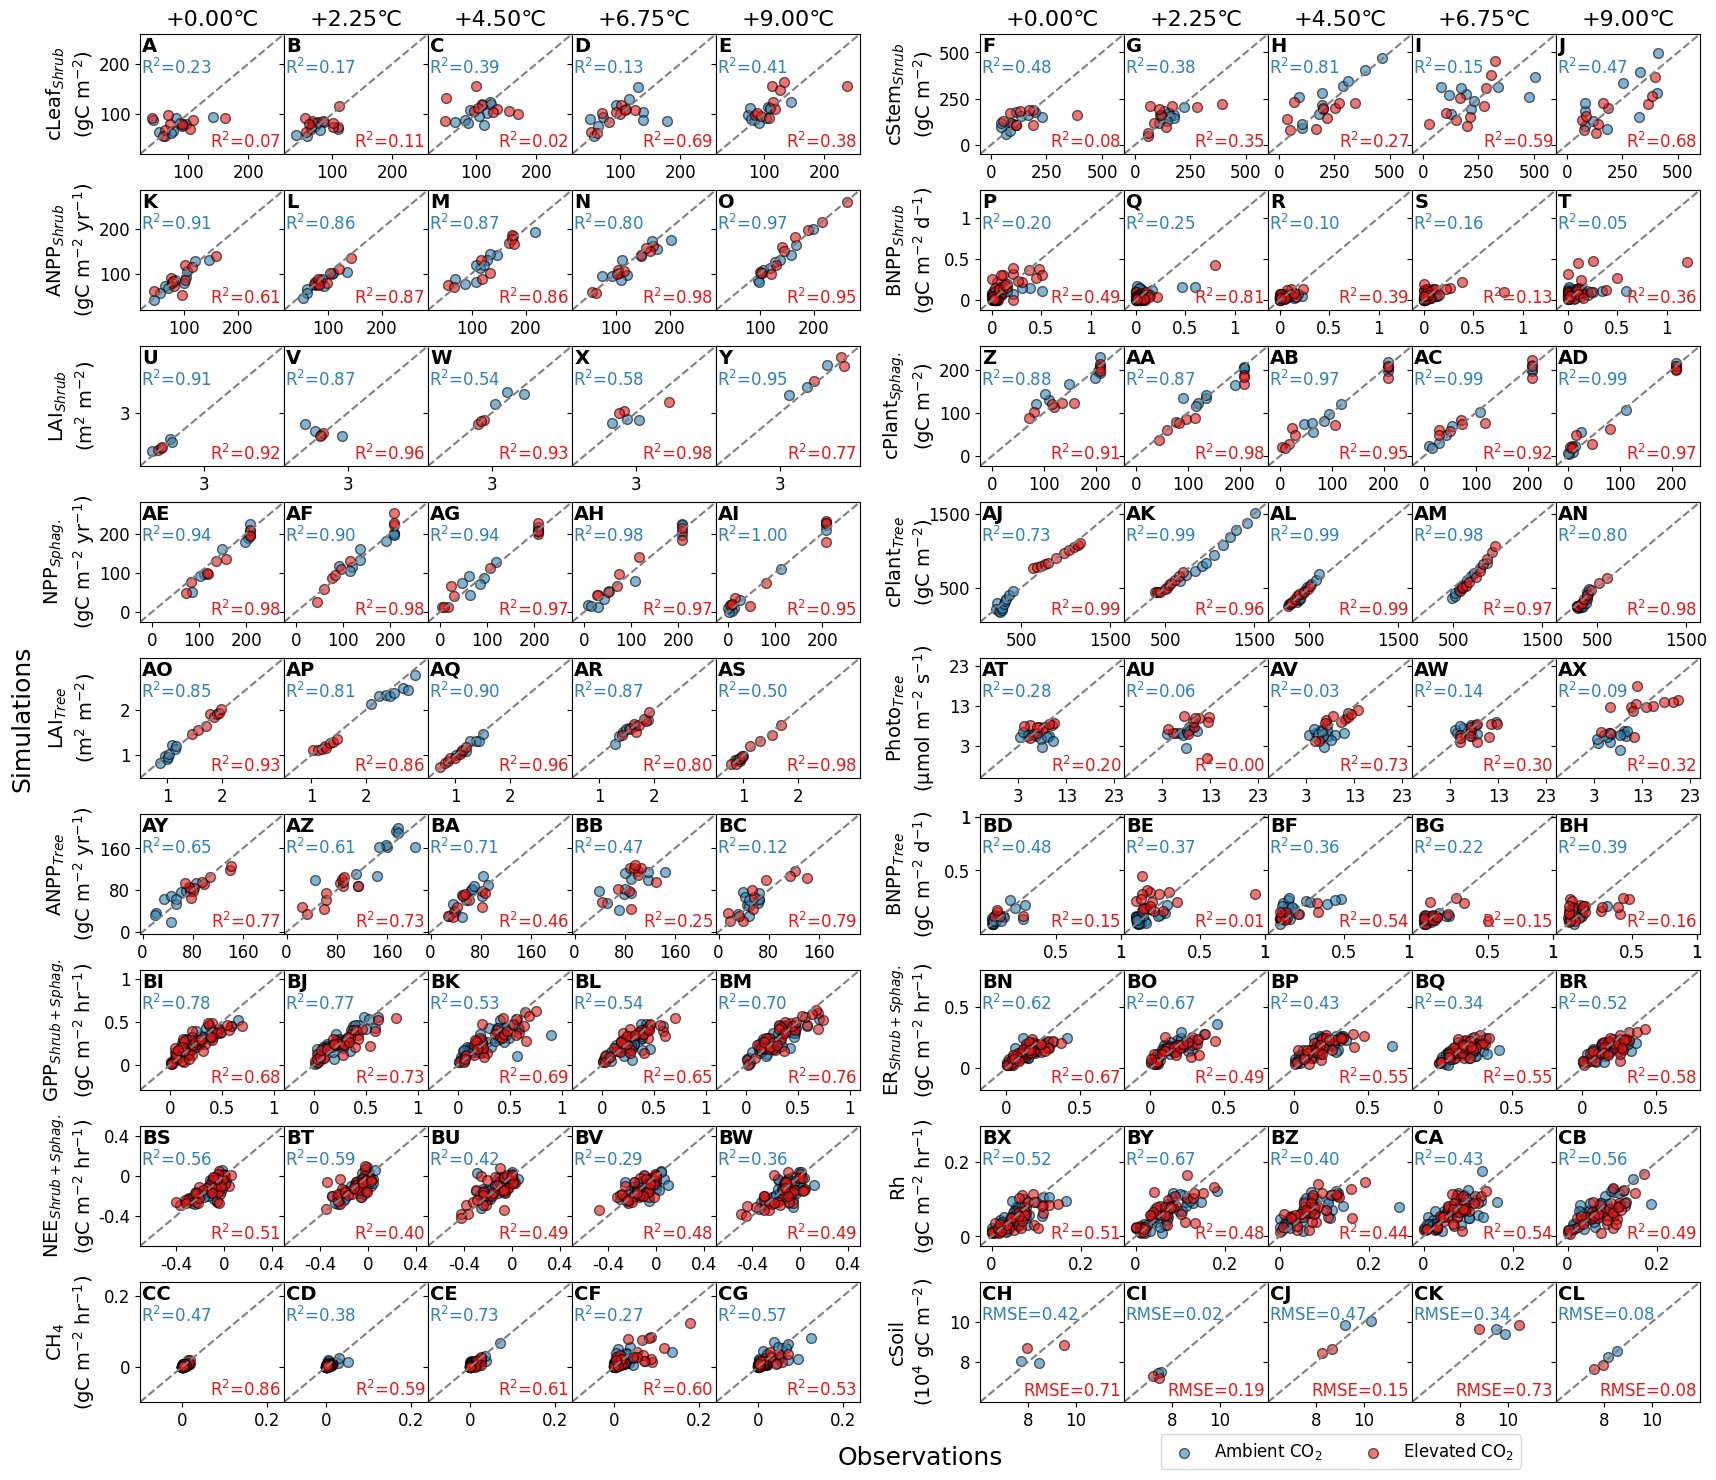

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import string
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.api as sm

file_names = {
              "cleafshrub": 'obsfile_Shrub_cLeaf_y.txt',
              "cstemshrub": 'obsfile_Shrub_cStem_y.txt',
              "anppshrub": 'obsfile_Shrub_ANPP_y.txt',
              "bnppshrub_d": 'obsfile_Shrub_BNPP_d.txt',
              "laishrub": 'obsfile_Shrub_LAI_h.txt',
              "cplantsphag": 'obsfile_Sphag_cPlant_y.txt',
              "nppsphag": 'obsfile_Sphag_NPP_y.txt',
              
              "cplanttree": 'obsfile_Tree_PlantC_y.txt',
              "laitree": 'obsfile_Tree_LAI_h.txt',
              "phototree": 'obsfile_Tree_Photo_h.txt',
              "anpptree": 'obsfile_Tree_ANPP_y.txt',
              "bnpptree_d": 'obsfile_Tree_BNPP_d.txt',
              
              "gpp": 'obsfile_gpp_h.txt',
              "er": 'obsfile_er_h.txt',
              "nee": 'obsfile_nee_h.txt',
              "rh": 'obsfile_rh_h.txt',
              "ch4": 'obsfile_ch4_h.txt',
              "csoil": 'obsfile_cSoil_y.txt',
              }

ls_ylabels = ["cLeaf$_{Shrub}$\n(gC m$^{-2}$)", "cStem$_{Shrub}$\n(gC m$^{-2}$)", "ANPP$_{Shrub}$\n(gC m$^{-2}$ yr$^{-1}$)", "BNPP$_{Shrub}$\n(gC m$^{-2}$ d$^{-1}$)",
              "LAI$_{Shrub}$\n(m$^{2}$ m$^{-2}$)","cPlant$_{Sphag.}$\n(gC m$^{-2}$)", "NPP$_{Sphag.}$\n(gC m$^{-2}$ yr$^{-1}$)",
              "cPlant$_{Tree}$\n(gC m$^{-2}$)", "LAI$_{Tree}$\n(m$^{2}$ m$^{-2}$)", "Photo$_{Tree}$\n(μmol m$^{-2}$ s$^{-1}$)",
              "ANPP$_{Tree}$\n(gC m$^{-2}$ yr$^{-1}$)", "BNPP$_{Tree}$\n(gC m$^{-2}$ d$^{-1}$)", "GPP$_{Shrub+Sphag.}$\n(gC m$^{-2}$ hr$^{-1}$)", "ER$_{Shrub+Sphag.}$\n(gC m$^{-2}$ hr$^{-1}$)",
              "NEE$_{Shrub+Sphag.}$\n(gC m$^{-2}$ hr$^{-1}$)", "Rh\n(gC m$^{-2}$ hr$^{-1}$)", "CH$_{4}$\n(gC m$^{-2}$ hr$^{-1}$)", 
              "cSoil\n(10$^4$ gC m$^{-2}$)"             
]

def get_subplot_label(n):
    alphabet = string.ascii_lowercase
    label = ''
    while True:
        n, r = divmod(n, 26)
        label = alphabet[r] + label
        if n == 0:
            break
        n -= 1  # Excel-like offset
    return f"{label}"

plot_names = [("P06", "P19"), ("P20", "P11"), ("P13", "P04"), ("P08", "P16"), ("P17", "P10")]

fig = plt.figure(figsize=(20, 18))

nrows, ncols = 9, 10
axes = []

left_margin = 0.11
bottom_margin = 0.12
h_gap = 0     
v_gap = 0.02    
group_gap = 0.06 

subplot_width = (1.0 - left_margin*2 - 4*h_gap - group_gap) / 10
subplot_height = (1.0 - bottom_margin*2 - (nrows - 1) * v_gap) / nrows

idx_abc = 0
for i in range(nrows):
    for j in range(ncols):
        # if i == nrows-1 and j>4: continue
        if j < 5:
            x = left_margin + j * (subplot_width + h_gap)
        else:
            x = left_margin + j * (subplot_width + h_gap) + group_gap

        y = 1.0 - bottom_margin - (i + 1) * subplot_height - i * v_gap

        ax = fig.add_axes([x, y, subplot_width, subplot_height])
        abc_label = get_subplot_label(idx_abc)
        ax.text(0.015,0.98,f"{abc_label.upper()}", va="top", ha="left", transform=ax.transAxes, fontsize=14, fontweight="bold")
        idx_abc += 1
        # ax.set_xticks([])
        # ax.set_yticks([])
        axes.append(ax)

# settings
ls_label_co2 = ["Ambient CO$_2$", "Elevated CO$_2$"]
ls_colors = ["#2F81B5", "#E51818"]
ls_pos    = [(0.01, 0.8), (0.98, 0.02)]
ls_rel_pos = [("left", "top"), ("right", "bottom")]
idx_var = 0
idx_ax  = 0
ls_xticks = [(100,200), (0,250,500), (100,200), (0,0.5,1), 
             (0,3,6),(0,100,200),(0,100,200), (500,1500),(1,2,4),
             (3,13,23), (0,80,160), (1,0.5,1), (0,0.5,1),
             (0,0.5), (-0.4,0,0.4),(0,0.2),(0,0.2),
             (8,10)]

for i in range(nrows):
    for j in range(2):
        # if i == nrows - 1 and j>0: continue
        ivar = list(file_names.keys())[idx_var]
        idx_var += 1
        ls_x = []
        ls_y = []
        ls_axes = []
        for idx_plot, (iaco2, ieco2) in enumerate(plot_names):
            ax = axes[idx_ax]
            if idx_plot == 0:
                ax.set_ylabel(ls_ylabels[idx_var-1], fontsize=14)
                
            ls_axes.append(ax)
            idx_ax+=1
            for idx_co2, ico2 in enumerate([iaco2, ieco2]):
                df_data = pd.read_excel(f"4_mod_vs_obs/{ico2}_{ivar}.xlsx")
            
                ls_obs  = df_data["mean"].to_list()
                ls_simu = df_data["simu"].to_list()

                # if ivar == "phototree":
                #     ls_obs  = [x * 0.0432 for x in ls_obs]
                #     ls_simu = [x * 0.0432 for x in ls_simu]

                x = np.array(ls_obs)
                y = np.array(ls_simu)
            
                ax.scatter(x, y, s=50, color=ls_colors[idx_co2], edgecolors="k", alpha=0.6, label=ls_label_co2[idx_co2])
                ls_x.extend(ls_obs)
                ls_y.extend(ls_simu) 

                # mark information
                try:
                    x_const = sm.add_constant(x)
                    model = sm.OLS(y, x_const).fit()
                    r2 = model.rsquared
                except Exception:
                    r2 = 0
                # r2 = r2_score(x, y)
                rmse = np.sqrt(mean_squared_error(x, y))
                if ivar == "csoil":
                    if rmse/10000<0.01:
                        ax.text(ls_pos[idx_co2][0], ls_pos[idx_co2][1], f'RMSE<0.01',  ha=ls_rel_pos[idx_co2][0],  va=ls_rel_pos[idx_co2][1],
                            transform=ax.transAxes, fontsize=12, color=ls_colors[idx_co2])
                    else:
                        ax.text(ls_pos[idx_co2][0], ls_pos[idx_co2][1], f'RMSE={rmse/10000:.2f}',  ha=ls_rel_pos[idx_co2][0],  va=ls_rel_pos[idx_co2][1],
                            transform=ax.transAxes, fontsize=12, color=ls_colors[idx_co2])
                else:
                    ax.text(ls_pos[idx_co2][0], ls_pos[idx_co2][1], f'R$^2$={r2:.2f}', ha=ls_rel_pos[idx_co2][0],  va=ls_rel_pos[idx_co2][1],
                            transform=ax.transAxes, fontsize=12, color=ls_colors[idx_co2])
        
            ax.tick_params(axis='x', labelsize=12)
            ax.tick_params(axis='y', labelsize=12)

            # ax.text(0.98, 0.02, f'R$^2$={r2:.2f}', va="bottom", ha="right", transform=ax.transAxes, fontsize=14)
            # if ivar == "csoil":
            #     ax.set_xticks([60000, 80000, 100000, 120000])
            #     ax.set_xticklabels([6, 8, 10, 12], fontsize=12)
            #     ax.set_yticks([60000, 80000, 100000, 120000])
            #     ax.set_yticklabels([6, 8, 10, 12], fontsize=12)
            if ivar == "csoil":
                x_ticks = [80000, 100000]
            else:
                x_ticks = ls_xticks[idx_var-1]
            x_ticks_label = ls_xticks[idx_var-1]
            if idx_plot == 0:
                ax.set_xticks(x_ticks)
                ax.set_xticklabels(x_ticks_label, fontsize=12)
                ax.set_yticks(x_ticks)
                ax.set_yticklabels(x_ticks_label, fontsize=12)
            else:
                # if ivar == "er":
                #     ax.set_xticks([0, 0.2, 0.4])
                #     ax.set_xticklabels([0, 0.2, 0.4])
                # else:
                ax.set_xticks(x_ticks)
                ax.set_xticklabels(x_ticks_label, fontsize=12)
                ax.set_yticks(x_ticks)
                ax.set_yticklabels([], fontsize=12)
            

            
            # if ivar == "cplanttree":
            #     ax.set_xticks([500, 1500])
            #     ax.set_xticklabels([500, 1500], fontsize=12)
            # if ivar == "nee":
            #     ax.set_xticks([-0.4, 0, 0.4])
            #     ax.set_xticklabels([-0.4, 0, 0.4], fontsize=12)
            #     ax.set_yticks([-0.4, 0, 0.4])
            #     ax.set_yticklabels([-0.4, 0, 0.4], fontsize=12)
        # --------------------------------------------------------
        ls_vals = ls_x.copy()
        ls_vals.extend(ls_y)

        val_min = np.nanmin(np.array(ls_vals))
        val_max = np.nanmax(np.array(ls_vals))
        val_min = val_min - np.abs(val_max - val_min) * 0.1
        val_max = val_max + np.abs(val_max - val_min) * 0.1

        if ivar == "gpp": val_min = -0.29; val_max = 1.1
        if ivar == "nee": val_min = -0.7;  val_max = 0.5
        if ivar == "er":  val_min = -0.18; val_max = 0.8
        if ivar == "ch4": val_min = -0.099; val_max = 0.24
        if ivar == "cstemshrub": val_min = -49; val_max=599
        if ivar == "csoil": val_min = 60000; val_max=120000
        if ivar == "phototree": val_min = -5; val_max=25
        

        for idx_plot in range(5):
            ax = ls_axes[idx_plot]
            ax.set_xlim((val_min, val_max))
            ax.set_ylim((val_min, val_max))
            ax.plot([val_min, val_max], [val_min, val_max], linestyle='--', color='grey')

ls_warmings = ["+0.00℃", "+2.25℃", "+4.50℃", "+6.75℃", "+9.00℃"]

for i in range(5):
    axes[i].set_title(ls_warmings[i], fontsize=16)
    axes[i+5].set_title(ls_warmings[i], fontsize=16)

# fig.align_ylabels(axes)
for ax in axes:
    ax.yaxis.set_label_coords(-0.3, 0.5)

axes[-4].legend(loc='upper left', ncol=2,
    bbox_to_anchor=(0.2, -0.2),fontsize=12)

fig.text(0.5, 0.085, 'Observations', ha='center', fontsize=18)
fig.text(0.045, 0.5, 'Simulations', va='center', rotation='vertical', fontsize=18)
# plt.savefig("2_results/5_figures/fig_ex3_r2_obs_simu.pdf", dpi=300, format="pdf", bbox_inches='tight')#, transparent=True)

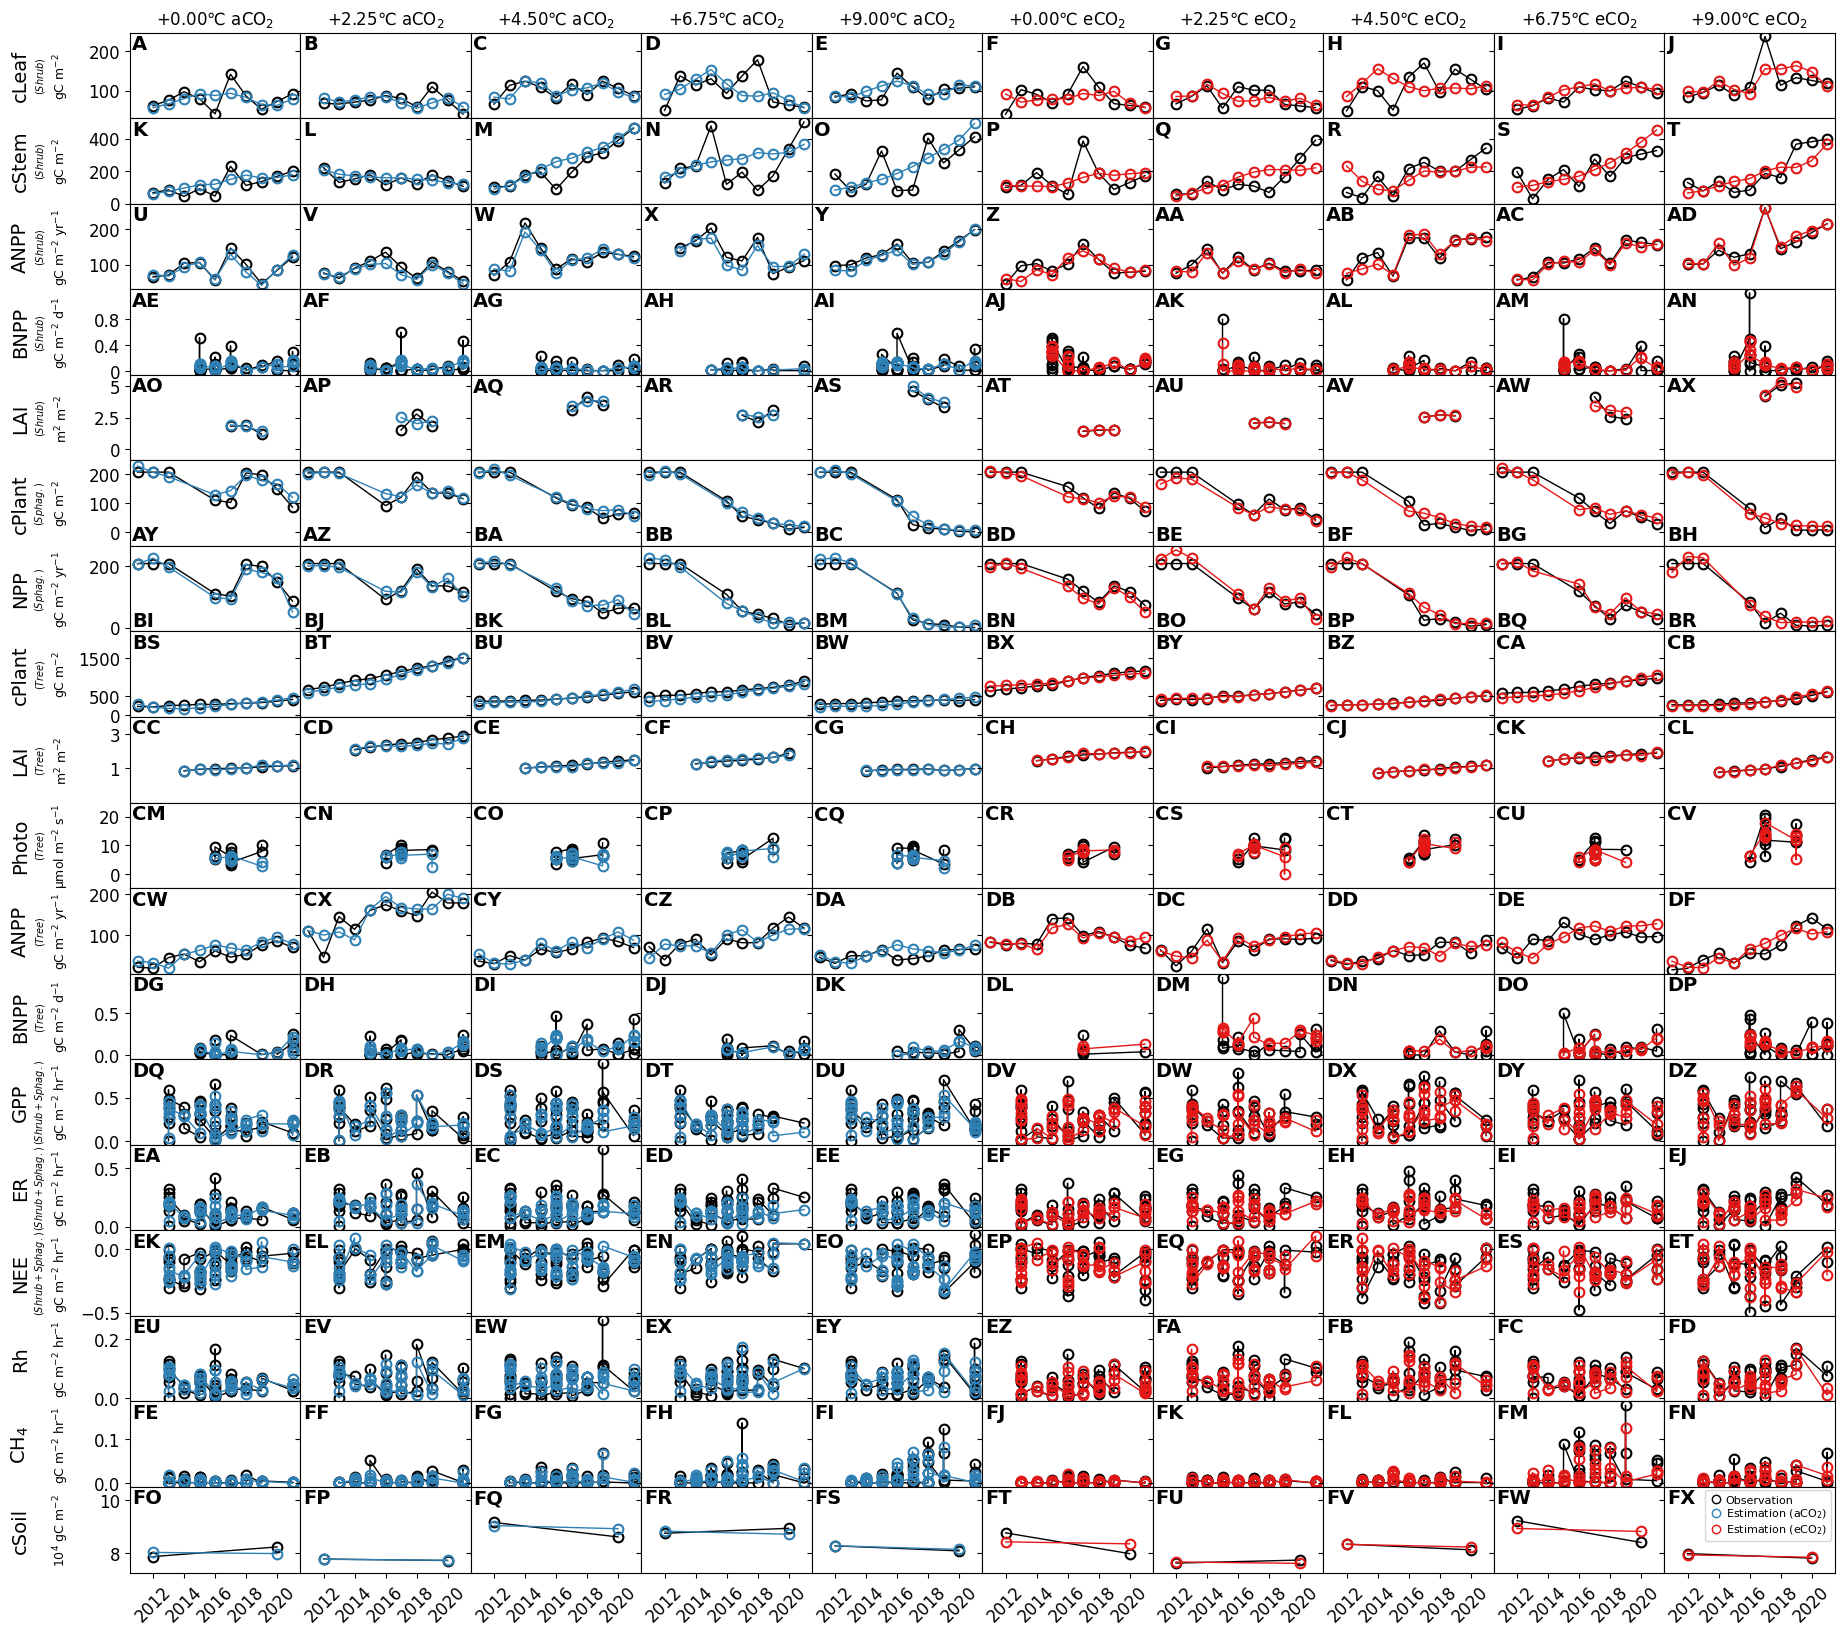

In [2]:
# time course
import pandas as pd
import matplotlib.pyplot as plt
import string
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.api as sm


ls_warmOnlyPlots = ["P06", "P20", "P13", "P08", "P17"]
ls_warmAndEleCO2 = ["P19", "P11", "P04", "P16", "P10"]

ls_plots = ["P06", "P20", "P13", "P08", "P17", "P19", "P11", "P04", "P16", "P10"]
# ls_plots = ["P08","P13", "P20"]
# ls_ylabels = ["cLeaf$_{Shrub}$\ngC m$^{-2}$", "cStem$_{Shrub}$\ngC m$^{-2}$", "ANPP$_{Shrub}$\ngC m$^{-2}$ yr$^{-1}$", "BNPP$_{Shrub}$\ngC m$^{-2}$ d$^{-1}$",
#               "cPlant$_{Sphag.}$\ngC m$^{-2}$", "NPP$_{Sphag.}$\ngC m$^{-2}$ yr$^{-1}$",
#               "cPlant$_{Tree}$\ngC m$^{-2}$", "LAI$_{Tree}$\nm$^{2}$ m$^{-2}$", "Photo$_{Tree}$\ngC m$^{-2}$ hr$^{-1}$",
#               "ANPP$_{Tree}$\ngC m$^{-2}$ yr$^{-1}$", "BNPP$_{Tree}$\ngC m$^{-2}$ d$^{-1}$", "GPP$_{Shrub+Sphag.}$\ngC m$^{-2}$ hr$^{-1}$", "ER$_{Shrub+Sphag.}$\ngC m$^{-2}$ hr$^{-1}$",
#               "NEE$_{Shrub+Sphag.}$\ngC m$^{-2}$ hr$^{-1}$", "Rh\ngC m$^{-2}$ hr$^{-1}$", "CH$_{4}$\ngC m$^{-2}$ hr$^{-1}$", 
#               "cSoil\n10$^4$ gC m$^{-2}$"             
# ]

ls_labels = ["+0.00℃ aCO$_2$", "+2.25℃ aCO$_2$", "+4.50℃ aCO$_2$", "+6.75℃ aCO$_2$", "+9.00℃ aCO$_2$",
             "+0.00℃ eCO$_2$", "+2.25℃ eCO$_2$", "+4.50℃ eCO$_2$", "+6.75℃ eCO$_2$", "+9.00℃ eCO$_2$"]


ls_ylabel_vars = ["cLeaf",    "cStem", "ANPP",  "BNPP", "LAI", "cPlant",  "NPP",  "cPlant", "LAI",
              "Photo",     "ANPP",   "BNPP",   "GPP",
              "ER", "NEE", "Rh", "CH$_{4}$", "cSoil"]

ls_ylabels_sub = ["$_{(Shrub)}$",    "$_{(Shrub)}$", "$_{(Shrub)}$",  "$_{(Shrub)}$", "$_{(Shrub)}$",
              "$_{(Sphag.)}$",  "$_{(Sphag.)}$",  "$_{(Tree)}$", "$_{(Tree)}$",
              "$_{(Tree)}$",     "$_{(Tree)}$",   "$_{(Tree)}$",   "$_{(Shrub+Sphag.)}$",
              "$_{(Shrub+Sphag.)}$","$_{(Shrub+Sphag.)}$", "", "", ""]

ls_units = ["gC m$^{-2}$",           "gC m$^{-2}$",           "gC m$^{-2}$ yr$^{-1}$", "gC m$^{-2}$ d$^{-1}$", "m$^{2}$ m$^{-2}$",
            "gC m$^{-2}$",           "gC m$^{-2}$ yr$^{-1}$", "gC m$^{-2}$",           "m$^{2}$ m$^{-2}$", 
            "μmol m$^{-2}$ s$^{-1}$", "gC m$^{-2}$ yr$^{-1}$", "gC m$^{-2}$ d$^{-1}$",  "gC m$^{-2}$ hr$^{-1}$", 
            "gC m$^{-2}$ hr$^{-1}$", "gC m$^{-2}$ hr$^{-1}$", "gC m$^{-2}$ hr$^{-1}$", "gC m$^{-2}$ hr$^{-1}$", 
            "10$^4$ gC m$^{-2}$"]

ls_colors = ["#2F81B5", "#2F81B5", "#2F81B5", "#2F81B5", "#2F81B5",
              "#E51818", "#E51818", "#E51818", "#E51818", "#E51818"]

def get_subplot_label(n):
    alphabet = string.ascii_lowercase
    label = ''
    while True:
        n, r = divmod(n, 26)
        label = alphabet[r] + label
        if n == 0:
            break
        n -= 1  # Excel-like offset
    return f"{label}"

fig, axes = plt.subplots(18,10, figsize=(22, 20), sharex=True, sharey='row')

idx_abc = 0

for idx_var, (ivar, ifile) in enumerate(file_names.items()):
    for idx_plot, iplot in enumerate(ls_plots):
        axes[0,idx_plot].set_title(ls_labels[idx_plot])
        ax = axes[idx_var, idx_plot]
        abc_label = get_subplot_label(idx_abc)
        if idx_var in [5, 6]:
            ax.text(0.015,0.015,f"{abc_label.upper()}", va="bottom", ha="left", transform=ax.transAxes, fontsize=14, fontweight="bold")
        else:
            ax.text(0.015,0.98,f"{abc_label.upper()}", va="top", ha="left", transform=ax.transAxes, fontsize=14, fontweight="bold")
        idx_abc +=1
        df_data = pd.read_excel(f"4_mod_vs_obs/{iplot}_{ivar}.xlsx")
        ax.plot(df_data["year"], df_data["mean"], marker='o', markerfacecolor='none', markeredgecolor="k", color="k", markersize=7, linewidth=1,markeredgewidth=1.5)
        ax.plot(df_data["year"], df_data["simu"], marker='o', markerfacecolor='none', markeredgecolor=ls_colors[idx_plot], color=ls_colors[idx_plot], markersize=7, linewidth=1,markeredgewidth=1.5)
        if idx_plot == 0:
            axes[idx_var,0].text(-0.64,0.5, ls_ylabel_vars[idx_var],transform=ax.transAxes,fontsize=14, va="center", ha="center", rotation="vertical")
            axes[idx_var,0].text(-0.52,0.5, ls_ylabels_sub[idx_var],transform=ax.transAxes,fontsize=10, va="center", ha="center", rotation="vertical")
            axes[idx_var,0].text(-0.4,0.5, ls_units[idx_var],      transform=ax.transAxes,fontsize=9, va="center", ha="center", rotation="vertical")
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)

for i in range(10):
    axes[17,i].set_xticks([2012,2014,2016,2018,2020])
    axes[17,i].set_xticklabels([2012,2014,2016,2018,2020], rotation=45)

ticks = [0,200,400]
axes[1,0].set_yticks(ticks)
axes[1,0].set_yticklabels(ticks)

ticks = [0,0.4,0.8]
axes[3,0].set_yticks(ticks)
axes[3,0].set_yticklabels(ticks)

axes[4,0].set_ylim(-0.9,5.9)
ticks = [0,2.5,5]
axes[4,0].set_yticks(ticks)
axes[4,0].set_yticklabels(ticks)

axes[5,0].set_ylim(-49,249)
ticks = [0,100,200]
axes[5,0].set_yticks(ticks)
axes[5,0].set_yticklabels(ticks)

axes[7,0].set_ylim(-49,2199)
ticks = [0,500,1500]
axes[7,0].set_yticks(ticks)
axes[7,0].set_yticklabels(ticks)

axes[8,0].set_ylim(-0.99, 4)
ticks = [1,3]
axes[8,0].set_yticks(ticks)
axes[8,0].set_yticklabels(ticks)

axes[9,0].set_ylim(-4.9,24.9)
ticks = [0,10,20]
axes[9,0].set_yticks(ticks)
axes[9,0].set_yticklabels(ticks)

ticks = [80000,120000]
axes[17,0].set_ylim(65000, 130000)
axes[17,0].set_yticks(ticks)
axes[17,0].set_yticklabels([8,10])

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='none', label='Observation',
           markerfacecolor='none', markeredgecolor='k', markersize=6, markeredgewidth=1),
    Line2D([0], [0], marker='o', color='none', label='Estimation (aCO$_2$)',
           markerfacecolor='none', markeredgecolor='#2F81B5', markersize=6, markeredgewidth=1),
    Line2D([0], [0], marker='o', color='none', label='Estimation (eCO$_2$)',
           markerfacecolor='none', markeredgecolor='#E51818', markersize=6, markeredgewidth=1),
]
axes[-1,-1].legend(handles=legend_elements, loc="upper right", fontsize=8,
                #    ax.legend(loc="upper right", ncol=1,
                    #  bbox_to_anchor=(ls_pox_legend[idx_ax][0], ls_pox_legend[idx_ax][1]),
                    labelspacing=0.2, 
                    columnspacing=0.7,
                    handlelength=1.2,
                    handletextpad=0.3,
                    borderaxespad=0.3 
        )

fig.align_ylabels(axes)
plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig("2_results/5_figures/fig_ex2_time_course_obs_simu.pdf", dpi=300, format="pdf", bbox_inches='tight')#, transparent=True)